In [7]:
from experiments.fedes.utils import load_data

In [8]:
trainset, testset = load_data()

Files already downloaded and verified
Files already downloaded and verified


In [9]:
trainset

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data/cifar100
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [50]:
labels = np.array(trainset.targets)
idx = np.array(range(len(labels)))
dataset = [idx, labels]
partitions, _ = fl.dataset.utils.common.create_lda_partitions(
    dataset, num_partitions=10, concentration=0.1, accept_imbalanced=True
)

In [67]:
from torch.utils.data import Subset

In [70]:
Subset(trainset, partitions[0][0])

(array([1001.,  702.,   44.,  114.,   13., 1012.,  647.,  307.,  853.,
         307.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <BarContainer object of 10 artists>)

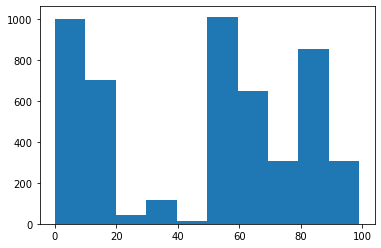

In [51]:
plt.hist(partitions[0][1])

In [28]:
import matplotlib.pyplot as plt

In [56]:
partitions[0][0]

array([21244,  4184, 37090, ..., 13317, 44563, 44562])

In [66]:
trainset.data[partitions[0][0]].shape

(5000, 32, 32, 3)

In [55]:
trainset[partitions[0][0]]

TypeError: only integer scalar arrays can be converted to a scalar index

<function flwr.dataset.utils.common.partition(x: numpy.ndarray, y: numpy.ndarray, num_partitions: int) -> List[Tuple[numpy.ndarray, numpy.ndarray]]>

In [11]:
from importlib import reload

import torch
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader
import numpy as np
import flwr as fl

from src.centralized.centralized import Net, load_data
from src.peer_reviewed import strategy
from src.peer_reviewed.prstrategy import PeerReviewStrategy


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
trainset, testset, _ = load_data()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
len(trainset)

50000

In [5]:
sampler = DistributedSampler(trainset, num_replicas=10, rank=0, shuffle=True)
loader = DataLoader(trainset, shuffle=False, sampler=sampler, batch_size=32)

In [6]:
next(iter(loader))[0].shape

torch.Size([32, 3, 32, 32])

In [7]:
total = 0
for batch_x, batch_y in loader:
    total += len(batch_x)
print(total)

5000


In [8]:
batch_x

tensor([[[[-0.2863, -0.2941, -0.3020,  ..., -0.3176, -0.2627, -0.3255],
          [-0.2235, -0.2549, -0.1373,  ..., -0.2000, -0.2549, -0.1843],
          [-0.2078,  0.0196,  0.1059,  ..., -0.1294, -0.1294,  0.0039],
          ...,
          [-0.7490, -0.8588, -0.8745,  ..., -0.3333, -0.3490, -0.2549],
          [-0.4510, -0.4745, -0.4980,  ..., -0.5294, -0.4510, -0.4275],
          [-0.2706, -0.2941, -0.2784,  ..., -0.2941, -0.2549, -0.2941]],

         [[-0.2863, -0.2863, -0.3020,  ..., -0.3176, -0.2627, -0.3176],
          [-0.2157, -0.2471, -0.1373,  ..., -0.1843, -0.2471, -0.1765],
          [-0.2078,  0.0275,  0.1059,  ..., -0.0902, -0.1137,  0.0039],
          ...,
          [-0.7647, -0.8588, -0.8667,  ..., -0.3098, -0.3412, -0.2549],
          [-0.4667, -0.4745, -0.4902,  ..., -0.5059, -0.4510, -0.4275],
          [-0.2784, -0.2941, -0.2784,  ..., -0.2941, -0.2549, -0.2941]],

         [[-0.3098, -0.3255, -0.3098,  ..., -0.3333, -0.2392, -0.3176],
          [-0.2471, -0.2863, -

In [9]:
total = np.zeros(10)
for batch_x, batch_y in loader:
    total += np.bincount(batch_y.numpy(), minlength=10)
print(total)

[519. 514. 520. 476. 509. 490. 520. 497. 463. 492.]


In [10]:
trainloader = DataLoader(trainset, shuffle=True, batch_size=32)
testloader = DataLoader(testset, shuffle=True, batch_size=32)

In [11]:
net = Net().to(DEVICE)

In [12]:
criterion = torch.nn.CrossEntropyLoss(reduction="sum")
correct, total, loss = 0, 0, 0.0
net.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = net(images)
        loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
loss /= len(testloader.dataset)
accuracy = correct / total

In [13]:
loss

2.305141393661499

In [14]:
accuracy

0.0921

In [16]:
reload(strategy)
isinstance(strategy.PeerReviewedFedAvg(), fl.server.strategy.Strategy)

True